# Data Science Project 2025/2026
#### Authors: Alexis Barros 2045719 & Vitor Remesso 2050519

## Problem Formulation
The dataset is a collection of flight delays and cancellations raging from the year 2019 to 2023, from the 'US Department of Transportation, Bureau of Transportation Statistics'. With this, we aim to predict arrival delay duration (in minutes) for a given flight based on scheduled times, airline, route, distance, and operational factors (using regression models). We will classify flights into three categories: 'On Time' (arrival delay < 15 minutes), 'Delayed' (arrival delay 15-30 minutes), and 'Long Delay' (arrival delay > 30 mins). In addition, we will identify patterns in operational performance by clustering, such as 'Airports based on delay behavior and traffic characteristics', and 'Airlines based on punctuality, delay causes, and route profiles'. Finally, we will test statistical hypothesis to determine if there are significant differences in delay patterns between different airlines, routes, or time periods.


Post-pandemic operations (2022-2023) suffered more carrier-related delays due to staff shortages than pre-pandemic (2019) operations.


In [41]:
# Libraries

import pandas as pd
import importlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
import numpy as np

# Data Analysis
## Data Load

In [42]:
import data_loader

importlib.reload(data_loader)


# Load the dataset
loader = data_loader.DataLoader()
df_flights = loader.data




Data Preview:
      FL_DATE                AIRLINE                AIRLINE_DOT AIRLINE_CODE  \
0  2019-01-09  United Air Lines Inc.  United Air Lines Inc.: UA           UA   
1  2022-11-19   Delta Air Lines Inc.   Delta Air Lines Inc.: DL           DL   
2  2022-07-22  United Air Lines Inc.  United Air Lines Inc.: UA           UA   
3  2023-03-06   Delta Air Lines Inc.   Delta Air Lines Inc.: DL           DL   
4  2020-02-23       Spirit Air Lines       Spirit Air Lines: NK           NK   

   DOT_CODE  FL_NUMBER ORIGIN          ORIGIN_CITY DEST  \
0     19977       1562    FLL  Fort Lauderdale, FL  EWR   
1     19790       1149    MSP      Minneapolis, MN  SEA   
2     19977        459    DEN           Denver, CO  MSP   
3     19790       2295    MSP      Minneapolis, MN  SFO   
4     20416        407    MCO          Orlando, FL  DFW   

               DEST_CITY  ...  DIVERTED  CRS_ELAPSED_TIME  ELAPSED_TIME  \
0             Newark, NJ  ...       0.0             186.0         176.0   


## Dataset Description

Each row in the dataset corresponds to a single scheduled commercial flight. The columns are:

### Flight-related:
- **FL_DATE**: Date of the flight (YYYY-MM-DD).
- **AIRLINE**: Airline name.
- **AIRLINE_DOT**: Airline name standardized by the U.S. Department of Transportation.
- **AIRLINE_CODE**: Two-letter IATA airline code.
- **DOT_CODE**: Unique DOT identifier for the airline.
- **FL_NUMBER**: Flight number assigned by the airline.
- **ORIGIN**: IATA airport code of the departure airport.
- **ORIGIN_CITY**: City and state of the departure airport.
- **DEST**: IATA airport code of the destination airport.
- **DEST_CITY**: City and state of the destination airport.

### Scheduled and actual times:
- **CRS_DEP_TIME**: Scheduled departure time.
- **DEP_TIME**: Actual departure time.
- **CRS_ARR_TIME**: Scheduled arrival time.
- **ARR_TIME**: Actual arrival time.

### Delay metrics:
- **DEP_DELAY**: Departure delay in minutes (actual departure minus scheduled departure). Negative values indicate early departure.
- **ARR_DELAY**: Arrival delay in minutes (actual arrival minus scheduled arrival). This variable is commonly used to define whether a flight is delayed.
- **TAXI_OUT**: Time (in minutes) from gate departure to wheels-off.
- **TAXI_IN**: Time (in minutes) from wheels-on to arrival at the gate.
- **WHEELS_OFF**: Time when the aircraft leaves the ground.
- **WHEELS_ON**: Time when the aircraft touches down.

### Flight duration and distance:
- **CRS_ELAPSED_TIME**: Scheduled total flight time (minutes).
- **ELAPSED_TIME**: Actual total flight time (minutes).
- **AIR_TIME**: Time spent in the air (minutes).
- **DISTANCE**: Distance between origin and destination airports (miles).

### Flight Status Indicators:
- **CANCELLED**: Binary indicator (1 if the flight was cancelled, 0 otherwise).
- **CANCELLATION_CODE**: Reason for cancellation (e.g., weather, carrier, airspace).
- **DIVERTED**: Binary indicator (1 if the flight was diverted to another airport).

### Causes of delay (in minutes):
These fields are typically populated when the arrival delay is 15 minutes or more:
- **DELAY_DUE_CARRIER**: Delay caused by airline-related issues.
- **DELAY_DUE_WEATHER**: Delay caused by weather conditions.
- **DELAY_DUE_NAS**: Delay due to the National Airspace System (e.g., congestion).
- **DELAY_DUE_SECURITY**: Delay caused by security issues.
- **DELAY_DUE_LATE_AIRCRAFT**: Delay due to the late arrival of the aircraft from a previous flight.


# Data Preprocessing / Cleaning
## Dropping irrelevant columns
We will drop columns that are not relevant for our analysis.

In [44]:
import data_preprocess

importlib.reload(data_preprocess)

processor = data_preprocess.DataPreprocess(df_flights, verbose=True)
df_flights_clean = (
    processor.drop_columns()
             .report_missing_values()
             .filter_cancelled_diverted()
             .clean_na()
             .timestamp_to_datetime()
             .timestamp_to_date()
             .encode_cyclical_time()
             .get_data()
)

      FL_DATE  DOT_CODE          ORIGIN_CITY              DEST_CITY  \
0  2019-01-09     19977  Fort Lauderdale, FL             Newark, NJ   
1  2022-11-19     19790      Minneapolis, MN            Seattle, WA   
2  2022-07-22     19977           Denver, CO        Minneapolis, MN   
3  2023-03-06     19790      Minneapolis, MN      San Francisco, CA   
4  2020-02-23     20416          Orlando, FL  Dallas/Fort Worth, TX   

   CRS_DEP_TIME  CRS_ARR_TIME  ARR_DELAY  CANCELLED  DIVERTED  \
0          1155          1501      -14.0        0.0       0.0   
1          2120          2315       -5.0        0.0       0.0   
2           954          1252        0.0        0.0       0.0   
3          1609          1829       24.0        0.0       0.0   
4          1840          2041       -1.0        0.0       0.0   

   CRS_ELAPSED_TIME  DISTANCE  
0             186.0    1065.0  
1             235.0    1399.0  
2             118.0     680.0  
3             260.0    1589.0  
4             181.0   

## Data splitting
We will split the dataset into training and testing sets for our predictive modeling tasks.

In [24]:
import data_split
importlib.reload(data_split)
splitter = data_split.DataSplit(df_flights_clean)

Data split successful: 2331041 training samples, 582761 testing samples. Scaled 9 numeric columns.
           FL_DATE                 AIRLINE                 AIRLINE_DOT  \
1479401 2020-10-02      Mesa Airlines Inc.      Mesa Airlines Inc.: YV   
258299  2023-06-10               Envoy Air               Envoy Air: MQ   
359329  2022-04-22      Mesa Airlines Inc.      Mesa Airlines Inc.: YV   
2866700 2019-06-11    Delta Air Lines Inc.    Delta Air Lines Inc.: DL   
2079939 2022-10-03    Alaska Airlines Inc.    Alaska Airlines Inc.: AS   
...            ...                     ...                         ...   
1113605 2019-06-11  American Airlines Inc.  American Airlines Inc.: AA   
1949617 2019-05-06   United Air Lines Inc.   United Air Lines Inc.: UA   
186002  2021-11-10        Republic Airline        Republic Airline: YX   
655491  2022-03-27    Delta Air Lines Inc.    Delta Air Lines Inc.: DL   
1845821 2023-02-08   United Air Lines Inc.   United Air Lines Inc.: UA   

        AIRL

# EDA and Visualization
## Delay Distribution
We will analyze the distribution of arrival delays to understand the overall delay patterns in the dataset.

Exploratory Data Analysis (EDA) Report:
--------------------------------------

Summary Statistics for train data:
                          FL_DATE      DOT_CODE     FL_NUMBER  CRS_DEP_TIME  \
count                     2331041  2.331041e+06  2.331041e+06  2.331041e+06   
mean   2021-05-10 07:00:40.661833  1.425474e-15  6.237791e-17  1.867436e-16   
min           2019-01-01 00:00:00 -1.549321e+00 -1.435908e+00 -2.729158e+00   
25%           2019-12-25 00:00:00 -4.949102e-01 -8.356862e-01 -8.469923e-01   
50%           2021-07-02 00:00:00 -1.230776e-01 -2.056820e-01 -1.710948e-02   
75%           2022-08-05 00:00:00  1.040227e+00  7.347426e-01  8.313067e-01   
max           2023-08-31 00:00:00  1.263327e+00  4.039974e+00  2.126583e+00   
std                           NaN  1.000000e+00  1.000000e+00  1.000000e+00   

       CRS_ARR_TIME  CRS_ELAPSED_TIME      DISTANCE       FL_YEAR  \
count  2.331041e+06      2.331041e+06  2.331041e+06  2.331041e+06   
mean  -1.286575e-16      1.878653e-

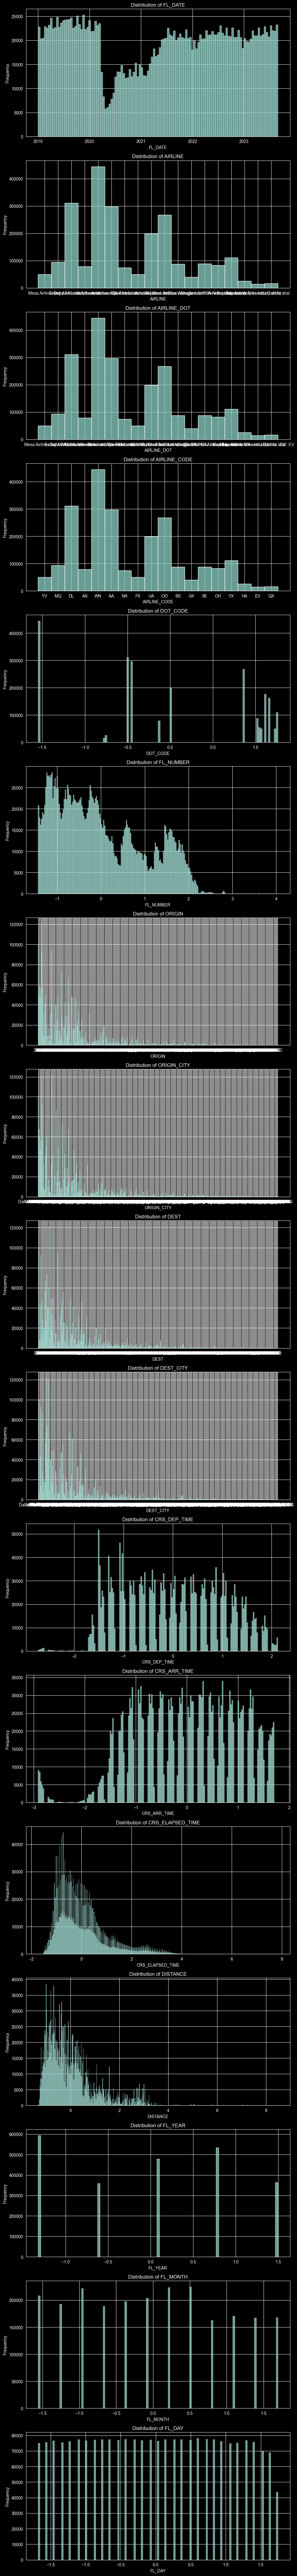


Correlation Analysis:


ValueError: could not convert string to float: 'Mesa Airlines Inc.'

In [34]:
import eda
importlib.reload(eda)

eda_instance = eda.EDA(splitter)
eda_instance.perform_eda()
